In [1]:
import pandas as pd
import numpy as np
import datetime
import re
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from functools import reduce
from sklearn.lda import LDA
import networkx as nx
import gensim
from gensim import corpora
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore
from nltk.corpus import stopwords
from scipy.ndimage.filters import gaussian_filter
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\Ofri\Anaconda3\lib\site-packages\sklearn\lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
C:\Users\Ofri\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Updates 5/6/18
* Removed outliers in the plots. For illustration purposes
* Remove users with id = -1

### Added the following features: 

1. number of posts per user
2. number of answers per user
3. user degree
4. user betweeness
5. is user part of a clique

## Utils

In [2]:
def cleanhtml(raw_html):
    """
    this function gets an html text and removes all the garbage marks
    """
    clean_code_r = re.compile('<code>.*?</code>')
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,'',re.sub(clean_code_r, '', raw_html))
    cleantext = cleantext.replace('\n',' ')
    return cleantext

def extract_code(raw_html):
    code_text = " ".join(re.findall(re.compile('<code>(.*?)</code>'),raw_html))
    return code_text

def clean_dataframe(df,int_columns,datetime_columns,text_columns):
    """
    This function gets a dataframe as an input and does the following transformations:
    1. type conversion - integers and datetime.
    2. clean html tags from text
    Important note: Unknown dates are converted to 1/1/1900
    """
    for col in int_columns:
        df[col]=df[col].fillna(0).astype(int)
    for col in datetime_columns:
        df[col]=[datetime.datetime.strptime(str(x),"%Y-%m-%dT%H:%M:%S.%f") if len(str(x))>4 else datetime.datetime(1900,1,1) for x in df[col]]
    for col in text_columns:
        df["%s_Code"%col]=[extract_code(text) for text in df[col]]
        df[col]=[cleanhtml(text) for text in df[col]]
    print(len(df))
    df = df[df['OwnerUserId']>0]
    print(len(df))
    return df
def get_post_label(post_id,parent_id,accepted_answer_ids):
    if post_id in accepted_answer_ids:
        return 'Accepted answer'
    elif parent_id > 0:
        return 'Answer'
    else:
        return 'Question'

## Read and clean posts data

In [3]:
tree = ET.parse('data/Posts.xml')
root = tree.getroot()
posts_df = pd.DataFrame([x.attrib for x in root.getchildren()])
posts_df.columns

Index(['AcceptedAnswerId', 'AnswerCount', 'Body', 'ClosedDate', 'CommentCount',
       'CommunityOwnedDate', 'CreationDate', 'FavoriteCount', 'Id',
       'LastActivityDate', 'LastEditDate', 'LastEditorDisplayName',
       'LastEditorUserId', 'OwnerDisplayName', 'OwnerUserId', 'ParentId',
       'PostTypeId', 'Score', 'Tags', 'Title', 'ViewCount'],
      dtype='object')

In [4]:
int_columns = int_columns=['AcceptedAnswerId','AnswerCount','CommentCount','FavoriteCount','Id','LastEditorUserId',
             'OwnerUserId','ParentId','PostTypeId','Score','ViewCount']
datetime_columns = ['ClosedDate','CommunityOwnedDate','CreationDate','LastActivityDate','LastEditDate']
text_columns=['Body']


posts_df = clean_dataframe(posts_df,int_columns,datetime_columns,text_columns)

19213
19068


## Assign labels
* If we want to add categories like 'high ranked'\'low ranked' we can just edit the get_label function

In [5]:
accepted_answer_ids = list(set(posts_df['AcceptedAnswerId']))
posts_df['post_label'] = [get_post_label(post_id,parent_id,accepted_answer_ids) for post_id,parent_id in zip(posts_df['Id'],posts_df['ParentId'])]
posts_df['post_label'].value_counts()

Question           8776
Answer             7300
Accepted answer    2992
Name: post_label, dtype: int64

## Questions score distribution

In [6]:
def show_distribution(df):
    n, bins, patches = plt.hist(df)
    plt.show()

In [7]:
questions_scores = sorted(posts_df[posts_df["post_label"]=="Question"]["Score"])

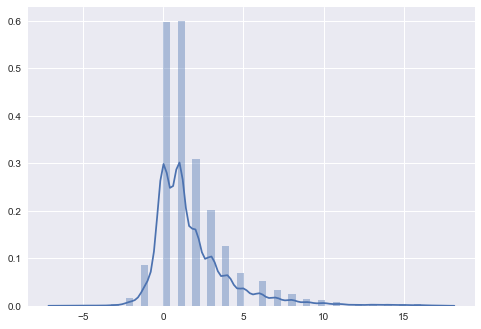

In [8]:
# Removed outliers for visualization purposes
sns.distplot(questions_scores[:int(len(questions_scores)*0.99)])

In [9]:
high_ranked_question_threshold = np.percentile(questions_scores, 90)
high_ranked_question_threshold

5.0

In [10]:
low_ranked_question_threshold = np.percentile(questions_scores, 10)
low_ranked_question_threshold

0.0

## Answers score distribution

In [11]:
answers_scores = sorted(posts_df[(posts_df["post_label"]=="Answer")|(posts_df["post_label"]=="Accepted answer")]["Score"])

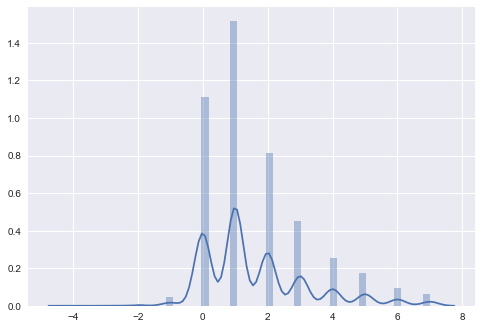

In [12]:
sns.distplot(answers_scores[:int(len(answers_scores)*0.95)])

In [13]:
high_ranked_answers_threshold = np.percentile(answers_scores, 90)
high_ranked_answers_threshold

5.0

In [14]:
low_ranked_answers_threshold = np.percentile(answers_scores, 10)
low_ranked_answers_threshold

0.0

## Label the posts rank

In [15]:
def get_post_rank(post_label,post_score):
    if post_label=="Question":
        if post_score>=high_ranked_question_threshold:
            return "High"
        elif post_score<=low_ranked_question_threshold:
            return "Low"
        else:
            return "Normal"
    else:
        if post_score>=high_ranked_answers_threshold:
            return "High"
        elif post_score<=low_ranked_answers_threshold:
            return "Low"
        else:
            return "Normal"

In [16]:
posts_df["post_rank"] = [get_post_rank(post_label,post_score) for post_label,post_score in zip(posts_df["post_label"],posts_df["Score"])]
posts_df['post_rank'].value_counts()

Normal    11477
Low        5334
High       2257
Name: post_rank, dtype: int64

## Stractural feature extraction

In [17]:
pos_tags = ["CC","CD","DT","EX","FW","IN","JJ","JJR","JJS","LS","MD","NN","NNS","NNP","NNPS","PDT","POS","PRP","PRP$","RB","RBR","RBS","RP","SYM","TO","UH","VB","VBD","VBG","VBN","VBP","VBZ","WDT","WP","WP$","WRB"]

In [18]:
question_feature_names = ["text_length","number_of_links","code_percentage"]
for tag in pos_tags:
    question_feature_names.append("%s_count"%tag)

In [19]:
def extract_stractural_features(df):
    df["text_length"] = df["Body"].map(lambda x: len(x)) + df["Body_Code"].map(lambda x: len(x))
    df["number_of_links"] = df["Body"].map(lambda x: x.count("http://"))
    df["code_percentage"] = df["Body_Code"].map(lambda x: len(x)) / df["text_length"]
    pos_counts = posts_df["Body"].map(lambda body: Counter([x[1] for x in pos_tag(word_tokenize(body))]))
    for tag in pos_tags:
        df["%s_count"%tag] = pos_counts.map(lambda x:x[tag])     

In [20]:
extract_stractural_features(posts_df)

In [21]:
posts_df

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CommunityOwnedDate,CreationDate,FavoriteCount,Id,LastActivityDate,...,VB_count,VBD_count,VBG_count,VBN_count,VBP_count,VBZ_count,WDT_count,WP_count,WP$_count,WRB_count
0,0,1,I've always been interested in machine learnin...,2014-05-14 14:40:25.950,1,1900-01-01 00:00:00.000,2014-05-13 23:58:30.457,1,5,2014-05-14 00:36:31.077,...,9,1,2,2,4,1,0,0,0,3
1,10,3,"As a researcher and instructor, I'm looking fo...",2014-05-14 08:40:54.950,4,1900-01-01 00:00:00.000,2014-05-14 00:11:06.457,1,7,2014-05-16 13:45:00.237,...,1,0,1,0,3,1,2,0,0,0
2,0,0,"Not sure if this fits the scope of this SE, bu...",1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 00:36:31.077,0,9,2014-05-14 00:36:31.077,...,12,2,6,1,6,7,4,2,0,2
3,0,0,"One book that's freely available is ""The Eleme...",1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 00:53:43.273,0,10,2014-05-14 00:53:43.273,...,0,0,1,1,1,6,1,0,0,0
4,29,4,I am sure data science as will be discussed in...,1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 01:25:59.677,4,14,2014-06-20 17:36:05.023,...,3,1,0,2,3,3,0,2,0,1
5,0,0,In which situations would one system be prefer...,2014-05-14 07:41:49.437,1,1900-01-01 00:00:00.000,2014-05-14 01:41:23.110,0,15,2014-05-14 01:41:23.110,...,1,0,0,1,1,0,1,1,0,0
6,46,2,I use Libsvm to train data and predict classif...,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 01:57:56.880,0,16,2014-05-17 16:24:14.523,...,4,2,0,0,2,2,1,0,0,0
7,0,0,LIBSVM is a library for support vector classif...,1900-01-01 00:00:00.000,0,1900-01-01 00:00:00.000,2014-05-14 02:49:14.580,0,17,2014-05-16 13:44:53.470,...,0,1,0,1,0,1,0,0,0,0
9,37,12,Lots of people use the term big data in a rath...,1900-01-01 00:00:00.000,5,1900-01-01 00:00:00.000,2014-05-14 03:56:20.963,16,19,2016-11-25 22:34:51.253,...,4,1,1,3,4,4,0,1,0,1
10,26,5,we created this social network application for...,1900-01-01 00:00:00.000,1,1900-01-01 00:00:00.000,2014-05-14 05:37:46.780,1,20,2017-08-29 11:26:37.137,...,1,1,3,3,2,6,0,0,0,1


In [22]:
def extract_answer_only_stractural_features(posts_df):
    question_answers_join = pd.merge(posts_df, posts_df,  how='left', left_on=['Id'], right_on = ['ParentId'])
    posts_df["text_length_ratio"] = question_answers_join.apply(lambda x: x["text_length_x"]/x["text_length_y"],axis=1)
    posts_df["code_length_ratio"] = question_answers_join.apply(lambda x: 0 if ((x["Body_Code_y"] is np.nan) or (len(x["Body_Code_x"])==0) or (len(x["Body_Code_y"]))==0) else len(x["Body_Code_x"])/len(x["Body_Code_y"]),axis=1)
    posts_df["response_time_difference"] = question_answers_join.apply(lambda x: x["CreationDate_y"]-x["CreationDate_x"],axis=1)

In [23]:
extract_answer_only_stractural_features(posts_df)

## Complicated features

In [24]:
vectorizer = TfidfVectorizer(sublinear_tf=True,
                                 stop_words='english',analyzer='word')
tf = vectorizer.fit_transform(posts_df["Body"])
posts_df["tf_idf"] = [x for x in tf.toarray()]

In [25]:
number_of_topics = 150
posts_df["Tags"] = posts_df["Tags"].map(lambda x: [] if (x is np.nan) else x.replace("<","").replace(">",",").strip(",").split(","))
tags = reduce(lambda x,y: x+y,posts_df["Tags"])
tags_freq = Counter(tags)
print(tags_freq.most_common(number_of_topics))

[('machine-learning', 2854), ('python', 1253), ('neural-network', 1168), ('deep-learning', 882), ('classification', 867), ('r', 711), ('data-mining', 613), ('scikit-learn', 505), ('nlp', 486), ('clustering', 443), ('predictive-modeling', 436), ('dataset', 413), ('keras', 378), ('time-series', 353), ('tensorflow', 344), ('regression', 339), ('text-mining', 316), ('statistics', 305), ('bigdata', 285), ('feature-selection', 236), ('visualization', 235), ('convnet', 217), ('random-forest', 214), ('pandas', 210), ('algorithms', 208), ('svm', 201), ('data-cleaning', 196), ('logistic-regression', 188), ('decision-trees', 181), ('data', 178), ('recommender-system', 165), ('xgboost', 157), ('linear-regression', 156), ('rnn', 152), ('apache-spark', 150), ('feature-extraction', 149), ('image-classification', 147), ('k-means', 126), ('cross-validation', 121), ('reinforcement-learning', 113), ('optimization', 110), ('multiclass-classification', 110), ('feature-engineering', 110), ('gradient-descent

In [26]:
topics_indexes = {x[0]:index for index,x in enumerate(tags_freq.most_common(number_of_topics))}

In [27]:
def get_topic_labels(x):
    labels = np.zeros(len(topics_indexes))
    indexes = []
    for topic in x:
        if topic in topics_indexes:
            indexes.append(topics_indexes[topic])
    labels[indexes] = 1
    return labels
posts_df["topics_labels"] = posts_df["Tags"].map(get_topic_labels)

In [28]:
def post_to_filtered_word_vector(post):
    return [word for word in word_tokenize(post.lower()) if word not in stopwords.words('english')]

In [29]:
def create_dictionary(post_body):
    body_vectors_filtered=[post_to_filtered_word_vector(body) for body in tqdm(post_body)]
    dictionary = corpora.Dictionary(body_vectors_filtered)
    return dictionary,body_vectors_filtered

In [30]:
dictionary,posts_words_vectors = create_dictionary(posts_df["Body"])

100%|██████████| 19068/19068 [18:07<00:00, 17.53it/s]
INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : adding document #10000 to Dictionary(58260 unique tokens: ["'ve", 'always', 'interested', 'machine', 'learning']...)
INFO : built Dictionary(101024 unique tokens: ["'ve", 'always', 'interested', 'machine', 'learning']...) from 19068 documents (total 2271292 corpus positions)


In [31]:
def train_lda(dictionary,posts_words_vectors,number_of_topics):
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in tqdm(posts_words_vectors)]
    return gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary, passes=10)

In [32]:
ldamodel = train_lda(dictionary,posts_words_vectors,number_of_topics)

100%|██████████| 19068/19068 [00:02<00:00, 6480.87it/s]
INFO : using symmetric alpha at 0.006666666666666667
INFO : using symmetric eta at 9.898637947418435e-06
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 150 topics, 10 passes over the supplied corpus of 19068 documents, updating model once every 2000 documents, evaluating perplexity every 19068 documents, iterating 50x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #2000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #76 (0.007): 0.038*"," + 0.023*"." + 0.019*":" + 0.015*")" + 0.011*"-" + 0.011*"(" + 0.009*"properties" + 0.007*"bauer" + 0.007*"data" + 0.006*"tables"
INFO : topic #118 (0.007): 0.031*"," + 0.023*":" + 0.020*"." + 0.016*")" + 0.015*"(" + 0.013*";" + 0.011*"=" + 0.011*"chararray" + 0.010*"'" + 0.010*"group"
INFO : topic #46 (0.007): 0.057*"," + 0.049*"." + 0.033*")" + 0.033*"(" + 0.020*"data" + 0

INFO : topic #63 (0.007): 0.035*"content" + 0.032*"!" + 0.028*"," + 0.027*"info" + 0.024*"?" + 0.021*"." + 0.020*"windows" + 0.016*"thank" + 0.015*"runs" + 0.014*"visual"
INFO : topic #60 (0.007): 0.170*"2" + 0.161*"1" + 0.130*"3" + 0.076*"4" + 0.063*"5" + 0.027*"6" + 0.018*"7" + 0.015*"." + 0.014*":" + 0.014*","
INFO : topic #53 (0.007): 0.064*"normal" + 0.053*"objective" + 0.040*"orange" + 0.029*"record" + 0.027*"patients" + 0.025*"disease" + 0.025*"merge" + 0.022*"learner" + 0.020*"sorted" + 0.020*"."
INFO : topic diff=3.181544, rho=0.353553
INFO : PROGRESS: pass 0, at document #18000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #56 (0.007): 0.054*"." + 0.052*"embedding" + 0.038*"correlation" + 0.038*"embeddings" + 0.025*"data" + 0.020*"," + 0.020*"article" + 0.017*"frames" + 0.015*"?" + 0.013*"address"
INFO : topic #35 (0.007): 0.164*")" + 0.164*"(" + 0.093*"=" + 0.084*"," + 0.056*"[" + 0.055*"]" + 0.040*":" + 0.019*"'" + 0.019*"impo

INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #138 (0.007): 0.219*"score" + 0.070*"scores" + 0.045*"auc" + 0.042*"red" + 0.038*"blue" + 0.029*"green" + 0.026*"rank" + 0.022*"," + 0.010*"gender" + 0.010*"color"
INFO : topic #59 (0.007): 0.467*"-" + 0.026*"," + 0.018*"hyperparameters" + 0.014*"==============================" + 0.013*"alpha" + 0.011*"." + 0.010*"tuning" + 0.010*"records" + 0.009*"hash" + 0.009*"hashing"
INFO : topic #93 (0.007): 0.086*"accuracy" + 0.067*"," + 0.041*"." + 0.032*"precision" + 0.031*"recall" + 0.018*"?" + 0.014*":" + 0.010*")" + 0.010*"(" + 0.009*"sizes"
INFO : topic #105 (0.007): 0.020*"mlc170314022391" + 0.020*"lcm04,2017-03-14" + 0.014*"synset" + 0.012*"ಅ" + 0.012*"ಂ" + 0.007*"ು" + 0.006*"," + 0.006*"ರ" + 0.005*"ಿ" + 0.005*"್"
INFO : topic #17 (0.007): 0.087*"." + 0.064*"," + 0.017*"regression" + 0.014*"feature" + 0.014*"use" + 0.012*"classification" + 0.012*")" + 0.012*"would" + 0.011*"logistic" + 0.010*"("
INFO 

INFO : topic #83 (0.007): 0.119*"weight" + 0.088*"kernel" + 0.078*"prediction" + 0.044*"weights" + 0.033*"recurrent" + 0.028*"display" + 0.021*"half" + 0.020*"." + 0.014*"rbf" + 0.013*"glm"
INFO : topic #59 (0.007): 0.630*"-" + 0.017*"," + 0.017*"alpha" + 0.015*"hash" + 0.013*"hashing" + 0.013*"contribute" + 0.010*"hyperparameters" + 0.007*"tuning" + 0.007*"." + 0.006*"beta"
INFO : topic #140 (0.007): 0.229*"image" + 0.166*"images" + 0.028*"color" + 0.025*"," + 0.017*"." + 0.013*"shown" + 0.013*"unseen" + 0.012*"clicks" + 0.009*"overlap" + 0.009*"scale"
INFO : topic diff=0.457194, rho=0.282459
INFO : PROGRESS: pass 2, at document #8000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #87 (0.007): 0.137*"split" + 0.064*"\text" + 0.043*"point" + 0.036*"hyperplane" + 0.033*"splits" + 0.024*"unable" + 0.023*"chosen" + 0.023*"2.0" + 0.012*"directed" + 0.012*"separating"
INFO : topic #9 (0.007): 0.462*"%" + 0.028*"shape" + 0.008*"bayesian" + 0.006

INFO : topic #56 (0.007): 0.081*"correlation" + 0.073*"embedding" + 0.062*"embeddings" + 0.059*"article" + 0.025*"frames" + 0.024*"address" + 0.022*"quality" + 0.021*"explains" + 0.020*"." + 0.018*"relationships"
INFO : topic #133 (0.007): 0.157*"state" + 0.039*"discrete" + 0.035*"current" + 0.035*"actions" + 0.034*"states" + 0.032*"cat" + 0.027*"rewards" + 0.026*"continuous" + 0.025*"optimal" + 0.024*"rl"
INFO : topic diff=0.143452, rho=0.282459
INFO : PROGRESS: pass 3, at document #2000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #49 (0.007): 0.095*"day" + 0.036*"numbers" + 0.032*"hour" + 0.031*"replace" + 0.027*"hours" + 0.025*"filtering" + 0.024*"entry" + 0.020*"author" + 0.020*"smote" + 0.019*"entries"
INFO : topic #79 (0.007): 0.220*"deep" + 0.105*"learning" + 0.081*"bias" + 0.032*"stanford" + 0.021*"variance" + 0.020*"lstms" + 0.017*"tutorial" + 0.015*"2016" + 0.014*"html" + 0.013*"recognition"
INFO : topic #48 (0.007): 0.153*"co

INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #35 (0.007): 0.187*")" + 0.187*"(" + 0.114*"=" + 0.091*"," + 0.047*":" + 0.029*"[" + 0.029*"]" + 0.021*"import" + 0.015*"'" + 0.012*"#"
INFO : topic #149 (0.007): 0.080*"cnn" + 0.043*"." + 0.036*"?" + 0.030*"window" + 0.026*"generator" + 0.026*"month" + 0.022*"old" + 0.016*"new" + 0.016*"cnns" + 0.012*","
INFO : topic #29 (0.007): 0.137*"?" + 0.039*"." + 0.038*"data" + 0.027*"understand" + 0.023*"," + 0.020*"outliers" + 0.017*"real" + 0.013*"use" + 0.013*"know" + 0.012*"used"
INFO : topic #23 (0.007): 0.247*"+" + 0.051*"*" + 0.027*"conv" + 0.019*"degree" + 0.019*"/" + 0.018*"character_size" + 0.016*"polynomial" + 0.013*"docs" + 0.013*"bot_x" + 0.013*"bot_y"
INFO : topic #17 (0.007): 0.085*"." + 0.073*"," + 0.024*"regression" + 0.019*"classification" + 0.018*"use" + 0.016*"classifier" + 0.015*"problem" + 0.014*"logistic" + 0.014*")" + 0.013*"model"
INFO : topic diff=0.069824, rho=0.271823
INFO : PROG

INFO : topic #129 (0.007): 0.189*"network" + 0.152*"neural" + 0.083*"networks" + 0.048*"activation" + 0.033*"weights" + 0.031*"function" + 0.028*"." + 0.026*"training" + 0.024*"sigmoid" + 0.020*","
INFO : topic #10 (0.007): 0.077*"company" + 0.043*"companies" + 0.042*"sequential" + 0.037*"optimizer" + 0.031*"segment" + 0.027*"transition" + 0.022*"factorization" + 0.020*"chain" + 0.018*"belonging" + 0.018*"light"
INFO : topic #6 (0.007): 0.289*"{" + 0.288*"}" + 0.036*"$" + 0.032*"=" + 0.023*"\frac" + 0.017*")" + 0.017*"\partial" + 0.016*"(" + 0.013*"^" + 0.011*"1"
INFO : topic #76 (0.007): 0.193*"file" + 0.099*"@" + 0.042*"csv" + 0.016*"load" + 0.014*"tables" + 0.010*"database" + 0.010*"hi" + 0.009*"tuple" + 0.007*"official" + 0.006*"81"
INFO : topic #86 (0.007): 0.031*"dummy" + 0.027*"outcome" + 0.027*"," + 0.021*"team" + 0.020*"ordinal" + 0.020*"." + 0.017*"predicts" + 0.015*"autoencoder" + 0.015*"overfit" + 0.014*"targets"
INFO : topic diff=0.059040, rho=0.262306
INFO : PROGRESS: pas

INFO : topic #37 (0.007): 0.176*"." + 0.081*"," + 0.016*"would" + 0.016*"use" + 0.015*"n't" + 0.011*"problem" + 0.011*"one" + 0.010*"good" + 0.010*"might" + 0.010*"try"
INFO : topic #46 (0.007): 0.102*"-1" + 0.039*"+1" + 0.037*"gradients" + 0.022*"health" + 0.017*"idx" + 0.013*"loop" + 0.013*"wise" + 0.013*"spread" + 0.011*"private" + 0.010*"slope"
INFO : topic diff=0.075719, rho=0.253722
INFO : PROGRESS: pass 5, at document #6000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #20 (0.007): 0.223*"cost" + 0.118*"net" + 0.063*"action" + 0.040*"conv2d" + 0.024*"0.8" + 0.023*"edited" + 0.021*"0.7" + 0.019*"measurement" + 0.017*"boolean" + 0.017*"failure"
INFO : topic #84 (0.007): 0.024*"command" + 0.022*"notebook" + 0.019*"script" + 0.017*"interactive" + 0.017*"path" + 0.015*"ipython" + 0.014*"environment" + 0.014*"server" + 0.013*"run" + 0.012*"paths"
INFO : topic #120 (0.007): 0.338*"x" + 0.104*"=" + 0.045*"(" + 0.044*")" + 0.036*"w" + 0.027

INFO : topic diff=0.057850, rho=0.253722
INFO : -7.223 per-word bound, 149.4 perplexity estimate based on a held-out corpus of 1068 documents with 135451 words
INFO : PROGRESS: pass 5, at document #19068/19068
INFO : merging changes from 1068 documents into a model of 19068 documents
INFO : topic #29 (0.007): 0.262*"?" + 0.036*"data" + 0.034*"understand" + 0.024*"." + 0.020*"know" + 0.019*"question" + 0.018*"real" + 0.016*"questions" + 0.016*"outliers" + 0.014*"use"
INFO : topic #57 (0.007): 0.154*"https" + 0.128*":" + 0.051*"imbalanced" + 0.038*"named" + 0.035*"entity" + 0.031*"resolution" + 0.028*"recognition" + 0.011*"winner" + 0.010*"adult" + 0.009*"1-"
INFO : topic #49 (0.007): 0.102*"day" + 0.043*"replace" + 0.034*"hour" + 0.032*"author" + 0.032*"filtering" + 0.031*"numbers" + 0.028*"hours" + 0.028*"smote" + 0.025*"1st" + 0.025*"entry"
INFO : topic #132 (0.007): 0.028*"imagenet" + 0.023*"inception" + 0.010*"inceptionv3" + 0.009*"nbsp" + 0.009*"train_index" + 0.008*"-n" + 0.007*"x

INFO : PROGRESS: pass 6, at document #14000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #104 (0.007): 0.080*"string" + 0.072*"sentences" + 0.067*"match" + 0.062*"sentence" + 0.048*"dictionary" + 0.038*"matching" + 0.030*"matches" + 0.027*"names" + 0.026*"encoded" + 0.024*"student"
INFO : topic #106 (0.007): 0.040*"city" + 0.036*"behavior" + 0.034*"timestep" + 0.032*"report" + 0.026*"timestamp" + 0.025*"coordinates" + 0.022*"timesteps" + 0.021*"cats" + 0.019*"dogs" + 0.018*"infer"
INFO : topic #110 (0.007): 0.120*"clustering" + 0.105*"cluster" + 0.063*"points" + 0.056*"algorithm" + 0.051*"data" + 0.046*"k-means" + 0.040*"filter" + 0.029*"filters" + 0.026*"." + 0.015*"hierarchical"
INFO : topic #131 (0.007): 0.072*"evaluation" + 0.041*"kaggle" + 0.025*"results" + 0.023*"evaluating" + 0.022*"compare" + 0.020*"ranked" + 0.018*"sites" + 0.017*"competitions" + 0.011*"err" + 0.011*"crime"
INFO : topic #117 (0.007): 0.244*"parameters" + 0.140*"

INFO : topic #108 (0.007): 0.093*"object" + 0.045*"objects" + 0.030*"regular" + 0.021*"authors" + 0.019*"structure" + 0.016*"parse" + 0.015*"identical" + 0.014*"a1" + 0.014*"." + 0.014*"properties"
INFO : topic diff=0.058806, rho=0.238814
INFO : PROGRESS: pass 7, at document #8000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #108 (0.007): 0.094*"object" + 0.052*"objects" + 0.031*"regular" + 0.023*"authors" + 0.018*"structure" + 0.015*"parse" + 0.014*"." + 0.013*"identical" + 0.013*"properties" + 0.013*"javascript"
INFO : topic #85 (0.007): 0.132*"items" + 0.123*"item" + 0.061*"articles" + 0.058*"v" + 0.036*"measures" + 0.036*"news" + 0.034*"metrics" + 0.032*"measure" + 0.016*"preference" + 0.013*"genre"
INFO : topic #29 (0.007): 0.289*"?" + 0.037*"data" + 0.032*"understand" + 0.025*"question" + 0.022*"know" + 0.020*"questions" + 0.018*"." + 0.015*"outliers" + 0.015*"use" + 0.012*"difference"
INFO : topic #11 (0.007): 0.076*"customer" + 0

INFO : PROGRESS: pass 8, at document #2000/19068
INFO : merging changes from 2000 documents into a model of 19068 documents
INFO : topic #97 (0.007): 0.277*"learning" + 0.162*"machine" + 0.044*"algorithms" + 0.035*"algorithm" + 0.023*"learn" + 0.022*"game" + 0.018*"." + 0.014*"book" + 0.014*"“" + 0.014*"ml"
INFO : topic #114 (0.007): 0.064*"x1" + 0.059*"x2" + 0.052*"looked" + 0.037*"combinations" + 0.036*"prices" + 0.028*"codes" + 0.025*"x3" + 0.020*"calls" + 0.014*"y." + 0.012*"'y1"
INFO : topic #16 (0.007): 0.669*"--" + 0.064*"|" + 0.031*"+" + 0.019*"-+" + 0.005*"3.0" + 0.003*"4.0" + 0.002*"2017-01-01" + 0.002*"`" + 0.002*"10.0" + 0.002*"-"
INFO : topic #89 (0.007): 0.043*"pipeline" + 0.032*"mapping" + 0.027*"connections" + 0.026*"relation" + 0.023*"spatial" + 0.023*"configuration" + 0.023*"position" + 0.022*"transactions" + 0.022*"creates" + 0.020*"human"
INFO : topic #88 (0.007): 0.308*"loss" + 0.056*"levels" + 0.025*"function" + 0.023*"acc" + 0.018*"0.49" + 0.016*"status" + 0.014*

INFO : topic #22 (0.007): 0.092*"0.0" + 0.068*"nan" + 0.031*"behaviour" + 0.022*"8758148.0" + 0.017*"multi-label" + 0.016*"child" + 0.016*"avg" + 0.015*"episode" + 0.013*"attached" + 0.013*"float64"
INFO : topic #65 (0.007): 0.157*"training" + 0.137*"set" + 0.133*"test" + 0.072*"train" + 0.049*"validation" + 0.027*"data" + 0.027*"testing" + 0.025*"cross" + 0.018*"." + 0.017*"sets"
INFO : topic #36 (0.007): 0.044*"transform" + 0.020*"tfidfvectorizer" + 0.020*"stacking" + 0.018*"rdd" + 0.017*"eta" + 0.016*"intersection" + 0.015*"vectorizer" + 0.015*"basket" + 0.015*"converted" + 0.014*"periodic"
INFO : topic #128 (0.007): 0.154*"vector" + 0.152*"word" + 0.103*"words" + 0.096*"vectors" + 0.027*"tags" + 0.021*"sentence" + 0.021*"tag" + 0.014*"paragraph" + 0.010*"ld" + 0.009*"corpus"
INFO : topic #71 (0.007): 0.072*"array" + 0.068*"e" + 0.056*"\\" + 0.038*"\end" + 0.038*"\begin" + 0.034*"bmatrix" + 0.029*"\mathbb" + 0.029*"y_" + 0.027*"\right" + 0.025*"\left"
INFO : topic diff=0.044459, rho

INFO : topic #130 (0.007): 0.067*"pattern" + 0.043*"frequent" + 0.041*"epochs" + 0.040*"mining" + 0.029*"stack" + 0.021*"relevance" + 0.020*"apriori" + 0.018*"apparently" + 0.017*"overflow" + 0.016*"saving"
INFO : topic #44 (0.007): 0.022*"regions" + 0.017*"____________________________________________________________________________________________________" + 0.014*"fitness" + 0.008*"analogous" + 0.008*"locality" + 0.006*"auto-encoder" + 0.006*"computers" + 0.005*"shuffling" + 0.005*"topological" + 0.005*"init="
INFO : topic #60 (0.007): 0.215*"1" + 0.209*"2" + 0.156*"3" + 0.095*"4" + 0.072*"5" + 0.034*"6" + 0.021*"7" + 0.015*":" + 0.014*"8" + 0.013*"10"
INFO : topic #109 (0.007): 0.090*"1.0" + 0.013*"tf.variable" + 0.013*"shape=" + 0.011*"tf.placeholder" + 0.011*"tf.matmul" + 0.010*"padding='same" + 0.010*"sess.run" + 0.010*"tf.float32" + 0.010*"mlp" + 0.009*"feed_dict="
INFO : topic diff=0.042954, rho=0.226258
INFO : PROGRESS: pass 9, at document #12000/19068
INFO : merging changes f

In [33]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [34]:
def smoothed_hist_kl_distance(a, b, nbins=10, sigma=1):
    ahist, bhist = (np.histogram(a, bins=nbins)[0],
                    np.histogram(b, bins=nbins)[0])

    asmooth, bsmooth = (gaussian_filter(ahist, sigma),
                        gaussian_filter(bhist, sigma))

    return KL(asmooth, bsmooth)

In [35]:
def topic_dist_to_arr(topic_dist):
    dist_1_arr = np.zeros(number_of_topics)
    dist_1_arr[[x[0] for x in topic_dist]]=[x[1] for x in topic_dist]
    return dist_1_arr

In [36]:
def calc_kld(topic_dist_1, topic_dist_2):
    if topic_dist_1 is None or topic_dist_1 is np.nan or topic_dist_2 is None or topic_dist_2 is np.nan:
        return -1.0
    dist_1_arr = topic_dist_to_arr(topic_dist_1)
    dist_2_arr = topic_dist_to_arr(topic_dist_2)
    return smoothed_hist_kl_distance(dist_1_arr,dist_2_arr)

In [37]:
def extract_topic_discribution_features(ldamodel,dictionary,posts_words_vectors):
    posts_df["topics_dist"] = [ldamodel[dictionary.doc2bow(post_words_vector)] for post_words_vector in tqdm(posts_words_vectors)]
    question_answers_join = pd.merge(posts_df, posts_df,  how='inner', left_on=['Id'], right_on = ['ParentId'])
    answers_indexes = question_answers_join["Id_y"].values
    kld_values = question_answers_join.apply(lambda x: calc_kld(x["topics_dist_x"],x["topics_dist_y"]),axis=1)
    tf_idf_similarity_values = question_answers_join.apply(lambda x: cosine_similarity(x["tf_idf_x"].reshape(1, -1),x["tf_idf_y"].reshape(1, -1))[0][0],axis=1)
    posts_df["kld"] = -1
    posts_df["tf_idf_similarity"] = -1
    for i,index in enumerate(tqdm(answers_indexes)):
        posts_df.loc[posts_df.Id==index,"kld"]=kld_values[i]
        posts_df.loc[posts_df.Id==index,"tf_idf_similarity"]=tf_idf_similarity_values[i]
    for topic_id in range(number_of_topics):
        posts_df["topic_dist_%s"%topic_id] = 0.0
    for index,topic_dist in enumerate(tqdm(posts_df["topics_dist"])):
        for topic,value in topic_dist:
            posts_df.iloc[index,posts_df.columns.get_loc("topic_dist_%s"%topic)]=value
    del question_answers_join
    del posts_df["topics_dist"]
    del posts_df["tf_idf"]

In [38]:
extract_topic_discribution_features(ldamodel,dictionary,posts_words_vectors)

100%|██████████| 19068/19068 [01:27<00:00, 218.31it/s]
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.
C:\Users\Ofri\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
100%|██████████| 19068/19068 [01:58<00:00, 161.17it/s]


# Create user related features

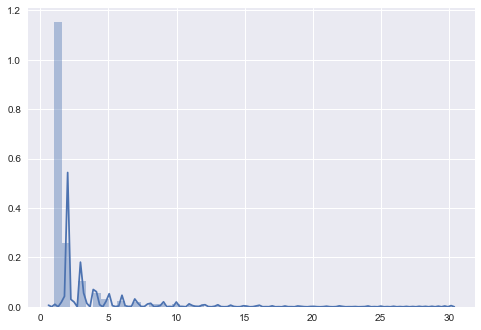

In [39]:
post_to_user_map = {k:v for k,v in zip(posts_df['Id'],posts_df['OwnerUserId'])}
user_to_num_of_posts_map = Counter(list(post_to_user_map.values()))
post_counts=sorted(list(user_to_num_of_posts_map.values()))
sns.distplot(post_counts[:int(len(post_counts)*0.99)])

## Calculate number of posts per user (prior to the given post)

In [40]:
user_to_number_of_posts_map={}
user_number_of_past_posts=[]
for index,row in posts_df.sort_values('CreationDate').iterrows():
    user_id = row['OwnerUserId']
    if user_id not in user_to_number_of_posts_map:
        user_to_number_of_posts_map[user_id] = 1
        user_number_of_past_posts.append(0)
    else:
        user_number_of_past_posts.append(user_to_num_of_posts_map[user_id])
        user_to_num_of_posts_map[user_id] += 1
posts_df['number_of_past_user_posts'] = user_number_of_past_posts

## Calculate number of accepted answers per user (prior to the given post)

In [41]:
user_to_number_of_accepted_answers_map={}
l=[]
for index,row in posts_df.sort_values('CreationDate').iterrows():
    user_id = row['OwnerUserId']
    if user_id not in user_to_number_of_accepted_answers_map:
        l.append(0)
    else:
        l.append(user_to_number_of_accepted_answers_map[user_id])
    if row['post_label'] == 'Accepted answer':
        if user_id not in user_to_number_of_accepted_answers_map:
            user_to_number_of_accepted_answers_map[user_id] = 0
        user_to_number_of_accepted_answers_map[user_id]+=1
posts_df['number_of_past_accepted_answers'] = l

## Calculate user degrees
* Degrees are number of users that the given user has communicated with

In [42]:
g = nx.Graph()
for index,row in posts_df[posts_df['post_label']!='Question'].iterrows():
    try:
        g.add_edge(row['OwnerUserId'],post_to_user_map[row['ParentId']])
    except:
        pass

nodes_degrees={}
for n in g.nodes():
    nodes_degrees[n] = g.degree(n)
degrees=[]
for user_id in posts_df['OwnerUserId']:
    try:
        degrees.append(nodes_degrees[user_id])
    except:
        degrees.append(0)
posts_df['user_degree']=degrees

## Calculate node betweeness

In [43]:
graph_betweeness = nx.betweenness_centrality(g)

In [44]:
betweeness=[]
for user_id in posts_df['OwnerUserId']:
    try:
        betweeness.append(graph_betweeness[user_id])
    except:
        betweeness.append(0)
posts_df['betweeness'] = betweeness

## find whether a user is a member of a certain clique

In [45]:
clique_members=[]
for clique in nx.find_cliques(g):
    if len(clique)>2:
        clique_members.extend(clique)
clique_members=list(set(clique_members))
is_clique_member=[]
for u_id in posts_df['OwnerUserId']:
    if u_id in clique_members:
        is_clique_member.append(1)
    else:
        is_clique_member.append(0)
posts_df['is_clique_member'] = is_clique_member

In [47]:
posts_df.to_csv("dataset_and_features.csv",encoding="utf8")